# Style transfer with NN

In this notebook, a style transfer method, as outlined in the paper [Image Style Transfer Using Convolutional Neural Networks, by Gatys, Ecker, Bethge](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), is recreated in PyTorch.

In this paper, style transfer uses the features found in the 19-layer [VGG Network](https://arxiv.org/abs/1409.1556). The network is constructed alternating convolutional and pooling layers, followed by a few fully-connected layers. The last fully connected layer has 1000 output nodes, one for each category in the original classifier.

### Separating Style and Content

Style transfer consists of creating an image taking the content from one image and the 'style' (color, texture) from another. The idea is to define "content" as the information encoded in the final layers of a deep CNN, i.e., those closer to the classifying layers; "style" is defined as the information encoded in the initial layers, where global information about the picture can be interpreted to be encoded. The network in question is a pre-trained VGG19. Then, content and style loss functions are defined, as the euclidean distances between the parameters in the content layers (resp. style) in the target image and the content image (resp. style). The output image is obtained by optimising the image parameters against (a combination of) these losses.

### Setup

In [1]:
# import resources
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load VGG19

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

Only the `features` portion is needed. Its weights are frozen, as they will have to remain fixed.

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Move the model to GPU, if available

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)

### Load content and style images

In [5]:
import image_utils

Load

In [6]:
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

style_img = image_utils.load_torch_image('images/matisse.jpg', mean = mean, std = std).to(device)
content_img = image_utils.load_torch_image('images/portrait.jpg', shape=style_img.shape[-2:], mean = mean, std = std).to(device)

Display

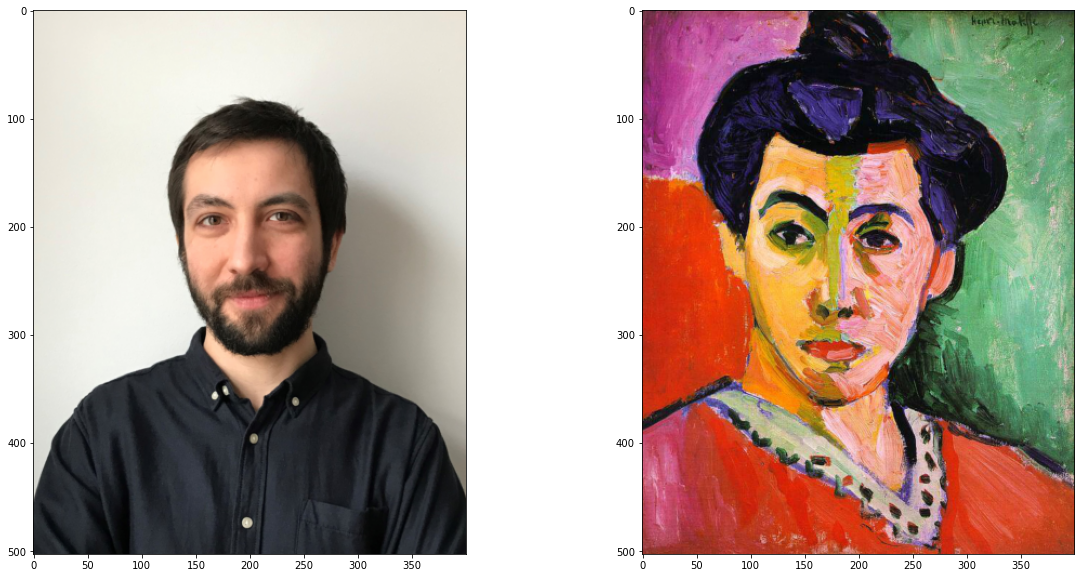

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image_utils.im_convert(content_img, mean = mean, std = std))
ax2.imshow(image_utils.im_convert(style_img, mean = mean, std = std))

# Loss and weights

#### Individual layer style weights

Single layers can be assigned weights. By weighting earlier layers (`conv1_1` and `conv2_1`) more, one can expect to get larger style artifacts in the resulting target image.

#### Content and Style Weight

Following the paper, content and stype weights are defined (`content_weight` and `style_weight`). Their ratio will affect how deformed the final image is. The variable style_weight increases the contribution of the style image. Each layer is assigned a different weight. Higher weights to earlier layers result in higher style deformation.

Note that the coefficients of the content representation conv4_2 are excluded (they should remain constant).

In [8]:
layer_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

In [9]:
content_weight = 1
style_weight = 1e6

#### Loss functions

In [10]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h*w)
    
    gram = torch.mm(tensor, torch.transpose(tensor, 0, 1))

    return gram

In [11]:
def get_content_loss(target_features, content_features, content_layer = 'conv4_2'):
    loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)
    return loss

In [12]:
def get_style_loss(target_features, style_features, style_weights):
    
    loss = 0
    
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
            
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        _, d, h, w = target_feature.shape
        
        loss += layer_loss / (d * h * w)
    
    return loss

# Updating the target image
The content image is modified transferring style from style image. The modified content image is named target.

#### Extract image features

In [13]:
def get_features(image, model):
    """ Run an image forward through a model and get the features for 
        a set of layers.
    """
    
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'
             }
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [14]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

target = content_img.clone().requires_grad_(True).to(device)

#### Training loop

In [15]:
# for displaying the target image intermittently
show_every = 1000

optimizer = optim.Adam([target], lr=0.003)
steps = 5000  

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = get_content_loss(target_features, content_features)    
    style_loss = get_style_loss(target_features, style_features, layer_weights)
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_utils.im_convert(target, mean = mean, std = std))
        plt.show()

KeyboardInterrupt: 

## Display and store the target image

In [ ]:
outcome_array = image_utils.im_convert(target, mean = mean, std = std)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_utils.im_convert(content_img, mean = mean, std = std))
ax2.imshow(outcome_array)

In [ ]:
outcome_img = Image.fromarray(outcome_array)
outcome_img.save('output/davide_matisse.jpg')